In [1]:
import utils as ut
import plot_utils as put

import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy
from tqdm.notebook import tqdm

In [2]:
PATH_ED = '../../energydroughts-Europe/data/'
ed = pd.read_csv(os.path.join(PATH_ED, 'netto_demand_el7_winter_LENTIS_2023_PD_1600_events.csv')).reset_index(drop=True)
ed['run'] = ed['runs'].str.extract('(\d+)').astype(int)
df_events = ed.drop(['Unnamed: 0', 'runs'], axis = 1)

In [3]:
ANOM_PATH = '/net/pc230050/nobackup/users/duinen/LENTIS/present'
PSL_PATH = '/net/pc200256/nobackup/users/most/LENTIS/present/day/psl_d'
dir_Figures = '../Results/Figures/composites_events/PD_2023_1600'
dir_Data = '/net/pc230050/nobackup/users/duinen/results/event_anomalies_per_country/PD_2023_1600'

In [4]:
ut.check_make_dir(dir_Figures)
ut.check_make_dir(dir_Data)

Creating dir ../Results/Figures/composites_events/PD_2023_1600
Creating dir /net/pc230050/nobackup/users/duinen/results/event_anomalies_per_country/PD_2023_1600


In [5]:
def create_composite_dataset(df_events):
    composite_datasets_by_country = {}

    for run in tqdm(np.arange(10, 170)):
        df_run = df_events.query('run == @run').sort_values(['country', 'start_time'])

        rsds_run = xr.open_dataset(f'{ANOM_PATH}/rsds_d_anomaly/anom_rsds_d_ECEarth3_h{run:03d}.nc')['rsds']
        sfcWind_run = xr.open_dataset(f'{ANOM_PATH}/sfcWind_d_anomaly/anom_sfcWind_d_ECEarth3_h{run:03d}.nc')['sfcWind'].drop_vars('height')
        t2m_run = xr.open_dataset(f'{ANOM_PATH}/tas_d_anomaly/anom_tas_d_ECEarth3_h{run:03d}.nc')['tas'].drop_vars('height')
        psl_run = xr.open_dataset(f'{PSL_PATH}/psl_d_ECEarth3_h{run:03d}.nc')['psl']

        for country in df_run.country.unique():
            times_run = []
            for event, row in df_run.query('country == @country').iterrows():
                timeseries_event = pd.date_range(start=row['start_time'], end=row['end_time'], freq='D')
                times_run.extend(timeseries_event)

            rsds_subset = rsds_run.sel(time=times_run)
            sfcWind_subset = sfcWind_run.sel(time=times_run)
            t2m_subset = t2m_run.sel(time=times_run)
            psl_subset = psl_run.sel(time=times_run)

            temp_dataset = xr.Dataset(
                {
                    'rsds': rsds_subset,
                    'sfcWind': sfcWind_subset,
                    'tas': t2m_subset,
                    'psl': psl_subset
                },
                coords={'time': times_run, 'lon': rsds_subset.lon, 'lat': rsds_subset.lat, 'country': country, 'run': run}
            )

            if country not in composite_datasets_by_country:
                composite_datasets_by_country[country] = []
            composite_datasets_by_country[country].append(temp_dataset)


    return composite_datasets_by_country

In [7]:
dataproj = ccrs.PlateCarree()
cmap = plt.cm.RdBu_r

def plot_composite_meteorology(country, composite_datasets_by_country):
    file_path = f'{dir_Data}/{country}_ds_events.nc'
    if os.path.exists(file_path):
        print('Already exists')
        ds_country = xr.open_dataset(file_path)
    else:
        ds_country = xr.concat(composite_datasets_by_country[country], dim = 'time')
        ds_country.to_netcdf(file_path)

    lons = ds_country.lon.values
    lats = ds_country.lat.values
    
    psl_country = ds_country.psl.mean(dim = 'time')
    tas_country = ds_country.tas.mean(dim = 'time')
    sfcWind_country = ds_country.sfcWind.mean(dim = 'time')
    rsds_country = ds_country.rsds.mean(dim = 'time')

    fig, axs = plt.subplots(3, 1, figsize=(6, 10), subplot_kw={'projection': dataproj})
    fig.subplots_adjust(right=0.8)

    vmin_list = [-10, -5, -30]
    vmax_list = [10, 5, 30]

    data = [tas_country, sfcWind_country, rsds_country]
    titles = ['Temperature', 'Wind speed', 'Radiation']
    cbar_units = ['[K]', '[m/s]', '[W/m²]']
    lon_lim, lat_lim = 40, 75

    for i in range(3):
        anom_plot = data[i]
        levels = np.linspace(vmin_list[i], vmax_list[i], 11)
        ax = axs.flat[i]
        psl_plot = psl_country / 100 # Pa to hPa
        ax.set_extent([lons[0], lon_lim, lats[0], lat_lim])
        ax.set_ylim([lats[0], 75])

        norm = colors.BoundaryNorm(levels, ncolors=cmap.N, extend = 'both')
        im = ax.contourf(lons, lats, anom_plot, levels=levels, cmap=cmap, norm=norm, extend = 'both')
        fig.colorbar(im, ax=ax, label = cbar_units[i])
        CS = ax.contour(lons, lats, psl_plot, colors='k')
        ax.clabel(CS, inline=True, fontsize=10)
        put.plot_maxmin_points(ax, lons, lats, lon_lim, lat_lim, psl_plot, 'max', 50, 'H', color='k',
                        plotValue=False, transform=dataproj)
        put.plot_maxmin_points(ax, lons, lats, lon_lim, lat_lim, psl_plot, 'min', 50, 'L', color='k',
                        plotValue=False, transform=dataproj)
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        ax.set_title(titles[i])
    fig.suptitle(f'Composite anomalies during {country} events')
    plt.tight_layout()
    plt.savefig(f'{dir_Figures}/{country}_composite_meteorology.png', dpi = 300)
    ds_country.close()


In [ ]:
composite_datasets_by_country = create_composite_dataset(df_events)

In [8]:
for country in tqdm(df_events.country.unique()):
    print(f'Starting {country}...')
    plot_composite_meteorology(country, composite_datasets_by_country)
    plt.close()

  0%|          | 0/29 [00:00<?, ?it/s]

Starting AUT...
Starting BEL...
Starting BGR...
Starting CHE...
Starting CZE...
Starting DEU...
Starting DNK...
Starting ESP...
Starting EST...
Starting FIN...
Starting FRA...
Starting GBR...
Starting GRC...
Starting HRV...
Starting HUN...
Starting IRL...
Starting ITA...
Starting LTU...
Starting LVA...
Starting NLD...
Starting NOR...
Starting POL...
Starting PRT...
Starting ROU...
Starting SRB...
Starting SVK...
Starting SVN...
Starting SWE...
Starting UKR...


Already exists


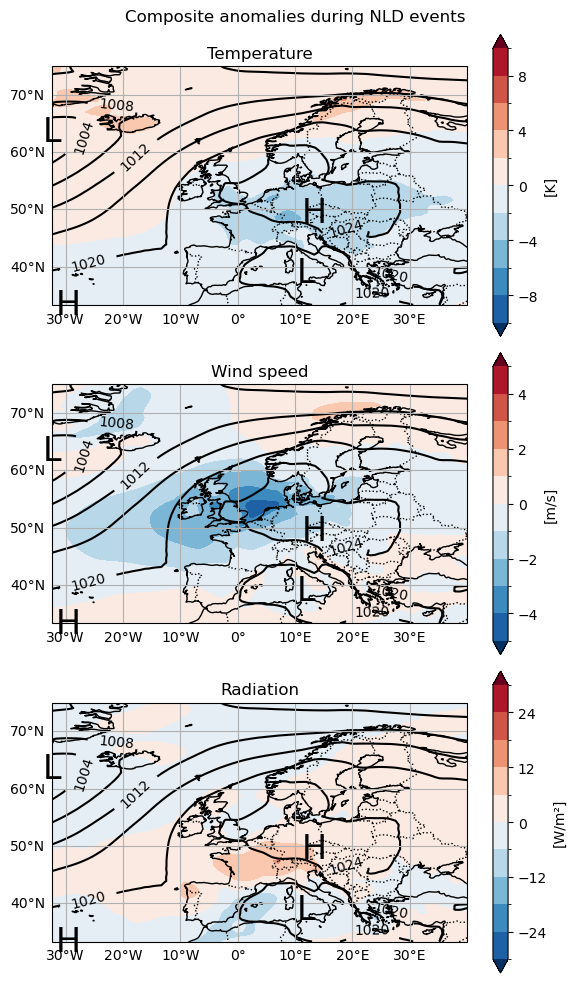

In [9]:
plot_composite_meteorology('NLD', composite_datasets_by_country)

Already exists


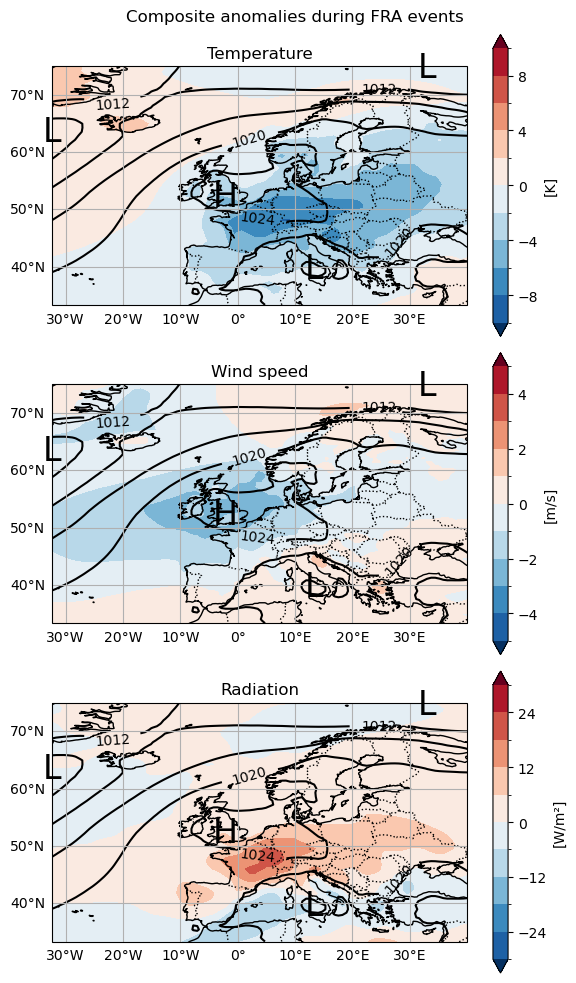

In [10]:
plot_composite_meteorology('FRA', composite_datasets_by_country)